In [1]:
import pandas as pd
import numpy
import nltk
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("data/processed_data.csv")
df["readme"].fillna("", inplace=True)

descriptions = df["readme"]
labels = df["label"]

In [2]:
# Build the Word Bag matrix
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(df['readme'].values)
count_vect_df = pd.DataFrame(counts.todense(), columns=count_vectorizer.get_feature_names())

In [3]:
# Data cleaning
stopwords = nltk.corpus.stopwords.words('english')
for word in stopwords:
    if word in df.columns:
        count_vect_df.drop(word, axis=1, inplace=True)
        
for col in count_vect_df.columns:
    # Remove words with no individual meanign
    if col in stopwords:
        count_vect_df.drop(col, axis=1, inplace=True)
    # Keep words which consist of letters only
    if not col.isalpha():
        count_vect_df.drop(col, axis=1, inplace=True)

count_vect_df.head()

,aawsat,aawsatcom,abandoned,abandons,abbreviations,abbreviationshttp,abdulaziz,ability,able,aboutcopyrightasp,...,zones,zopa,zopas,zu,zufehlerhaftem,zurich,zurichthe,zustzlicheprogramme,zxx,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 500, 1000, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(df['readme'].values, labels)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline.set_params(**best_parameters)
df['readme'].fillna('', inplace=True)
pipeline.fit(df['readme'].values, labels)

examples = ["homework", "app", "application"]
predictions = pipeline.predict(examples)
print(predictions)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__n_iter': (10, 50, 80),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.9min finished


done in 113.740s

Best score: 0.823
Best parameters set:
	clf__alpha: 1e-06
	clf__n_iter: 50
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
['HW' 'DATA' 'DEV']


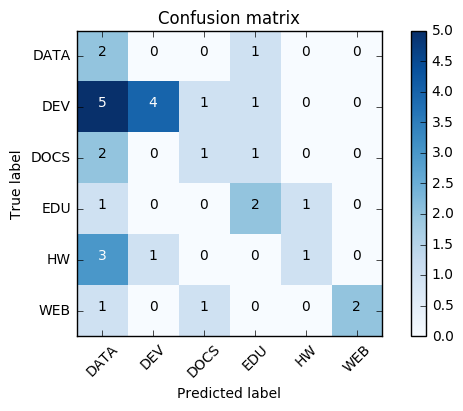

0.387096774194


In [65]:
from evaluation import get_accuracy_and_plot_confusion
val_df = pd.DataFrame.from_csv("data/validation_data.csv")
val_df["readme"].fillna("", inplace=True)
y_val = val_df.pop("label")
y_pred = pipeline.predict(val_df["readme"].values)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y_val) 

print(get_accuracy_and_plot_confusion(y_val, y_pred, le.classes_))

In [ ]:
grid_search.fit(df['description'].values, labels)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline.set_params(**best_parameters)
df['description'].fillna('', inplace=True)
pipeline.fit(df['description'].values, labels)

examples = ["homework", "app", "application"]
predictions = pipeline.predict(examples)
print(predictions)

In [42]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
targets = df['label'].values
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
for c in count_vect_df.columns:
    if sum(count_vect_df[c]) < 3:
        count_vect_df.drop(c, axis=1, inplace=True)
        
count_vect_df.describe()

,ability,able,absolute,academic,accept,access,accessible,accession,according,accounts,...,youre,yslam,yyyy,zemp,zenodoorg,zero,zika,zip,zu,zurich
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.024194,0.040323,0.032258,0.040323,0.024194,0.169355,0.056452,0.048387,0.032258,0.024194,...,0.064516,0.024194,0.040323,0.048387,0.024194,0.145161,0.032258,0.032258,0.048387,0.072581
std,0.200151,0.267454,0.252966,0.369557,0.154273,0.505607,0.344585,0.280963,0.177401,0.200151,...,0.277677,0.269408,0.296297,0.538816,0.200151,0.706457,0.359211,0.177401,0.400301,0.723287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,4.000000,1.000000,3.000000,3.000000,2.000000,1.000000,2.000000,...,2.000000,3.000000,3.000000,6.000000,2.000000,5.000000,4.000000,1.000000,4.000000,8.000000


In [16]:
examples = ["homework", "app", "application"]
example_counts = count_vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['DATA', 'DATA', 'DATA'], 
      dtype='|S4')